In [170]:
# imports
from tensorflow import keras
from keras.layers import Dense, Input
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.regularizers import l1

In [119]:
# Load dataset
(__X_train, y_train), (__X_test, y_test) = keras.datasets.mnist.load_data()

len(__X_train)

60000

In [191]:
def plot_sample(data):
    # create figure
    fig = plt.figure(figsize=(10, 7))
    n_imgs = 5
    
    for i in range(0, len(data)):
        for h in range(1, n_imgs+1):
            # Adds a subplot at the 1st position
            fig.add_subplot(len(data), 5, n_imgs*i + h)

            # showing image
            plt.imshow(np.reshape(data[i][0][h], (28, 28)))
            plt.axis('off')
            plt.title(data[i][1])

## Load and pre process data

In [120]:
_X_train = __X_train.astype('float32') / 255.0
_X_test = __X_test.astype('float32') / 255.0

input_size = 28*28
hidden_size = 128
code_size = 64

In [155]:
# Pre-process data
X_train = []
X_test = []
noisy_X_train = []
noisy_X_test = []

noise_factor = 0.4

for i in range(len(_X_train)):
    X_train.append(np.reshape(_X_train[i], (input_size,)))
    
for i in range(len(_X_test)):
    X_test.append(np.reshape(_X_test[i], (input_size,)))
    
for i in range(len(X_train)):
    noisy_X_train.append(X_train[i] + noise_factor * np.random.normal(0.0,1.0, len(X_train[i])))
    
for i in range(len(X_test)):
    noisy_X_test.append(X_test[i] + noise_factor * np.random.normal(0.0,1.0, len(X_test[i])))

X_train = np.array(X_train)
X_test = np.array(X_test)
noisy_X_train = np.array(noisy_X_train)
noisy_X_test = np.array(noisy_X_test)

len(X_train)

60000

## Reconstruction autoencoder

In [132]:
# Define model
input_layer = Input(shape=(input_size,))
encoder_layer = Dense(hidden_size, activation='relu')(input_layer)
code_layer = Dense(code_size, activation='relu')(encoder_layer)
decoder_layer = Dense(hidden_size, activation='relu')(code_layer)
output_layer = Dense(input_size, activation='sigmoid')(decoder_layer)

reconstruction_ae = keras.Model(input_layer, output_layer)
reconstruction_ae.compile(optimizer='adam', loss='binary_crossentropy')
reconstruction_ae.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_58 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_59 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_60 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_61 (Dense)             (None, 784)               101136    
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________


In [133]:
reconstruction_ae.fit(X_train, X_train, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1298
Epoch 2/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0911
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0850
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0820
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0800
Epoch 6/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0787
Epoch 7/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0778
Epoch 8/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0771
Epoch 9/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0766
Epoch 10/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0762
Epoch 11/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0759
Epoch 12/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0756
E

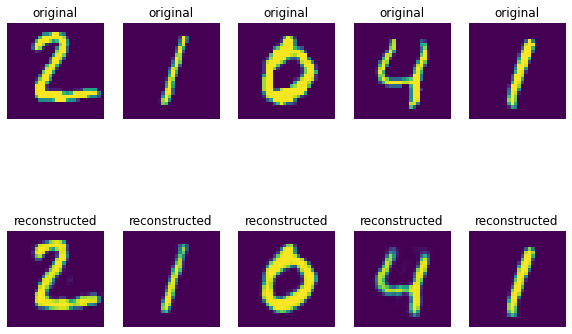

In [153]:
reconstructed = reconstruction_ae.predict(X_test)
plot_sample([(_X_test, 'original'), (reconstructed, 'reconstructed')])

## Denoiser autoencoder

In [175]:
# Define model
input_layer = Input(shape=(input_size,))
encoder_layer = Dense(hidden_size, activation='relu')(input_layer)
code_layer = Dense(code_size, activation='relu')(encoder_layer)
decoder_layer = Dense(hidden_size, activation='relu')(code_layer)
output_layer = Dense(input_size, activation='sigmoid')(decoder_layer)

denoiser_ae = keras.Model(input_layer, output_layer)
denoiser_ae.compile(optimizer='adam', loss='binary_crossentropy')
denoiser_ae.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_94 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_95 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_96 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_97 (Dense)             (None, 784)               101136    
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________


In [176]:
denoiser_ae.fit(noisy_X_train, X_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1493
Epoch 2/3
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1145
Epoch 3/3
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1085


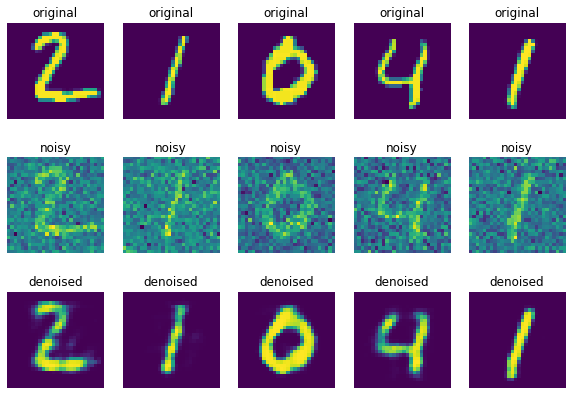

In [194]:
denoised = denoiser_ae.predict(noisy_X_test)
plot_sample([(X_test, 'original'), (noisy_X_test, 'noisy'), (denoised, 'denoised')])

## Sparse autoencoder

In [196]:
# Define model
input_layer = Input(shape=(input_size,))
encoder_layer = Dense(hidden_size, activation='relu', activity_regularizer=l1(10e-6))(input_layer)
code_layer = Dense(code_size, activation='relu', activity_regularizer=l1(10e-6))(encoder_layer)
decoder_layer = Dense(hidden_size, activation='relu', activity_regularizer=l1(10e-6))(code_layer)
output_layer = Dense(input_size, activation='sigmoid')(decoder_layer)

regularized_ae = keras.Model(input_layer, output_layer)
regularized_ae.compile(optimizer='adam', loss='binary_crossentropy')
regularized_ae.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_118 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_119 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_120 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_121 (Dense)            (None, 784)               101136    
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________


In [ ]:
regularized_ae.fit(noisy_X_train, X_train, epochs=40)

Epoch 1/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1534
Epoch 2/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1192
Epoch 3/40
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1129
Epoch 4/40
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1099
Epoch 5/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1078
Epoch 6/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1065
Epoch 7/40
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1055
Epoch 8/40
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1047
Epoch 9/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1041
Epoch 10/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1035
Epoch 11/40
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1031
Epoch 12/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1027
E

In [ ]:
regularized_denoised = regularized_ae.predict(noisy_X_test)
plot_sample([(X_test, 'original'), (noisy_X_test, 'noisy'), (regularized_denoised, 'regularized_denoised')])